You tube addview prediction 

We basically import preinstalled python libraries or packages like numpy, pandas, matplotlib, and
seaborn for data cleaning and visualisation. Scikit-learn and Keras are imported for machine learning
models and neural networks. Using the pandas library we can simply import the dataset in csv format
as a pandas dataframe. We can then explore the dataset and check the number of features and
samples in the data.

In [116]:
# 1. Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [117]:
data_train = pd.read_csv("train_lyst.csv")
print(data_train.head())

       vidid  adview    views likes dislikes comment   published duration  \
0  VID_18655      40  1031602  8523      363    1095  2016-09-14  PT7M37S   
1  VID_14135       2     1707    56        2       6  2016-10-01  PT9M30S   
2   VID_2187       1     2023    25        0       2  2016-07-02  PT2M16S   
3  VID_23096       6   620860   777      161     153  2016-07-27  PT4M22S   
4  VID_10175       1      666     1        0       0  2016-06-29    PT31S   

  category  
0        F  
1        D  
2        C  
3        H  
4        D  


In [118]:
print("Shape of dataset:", data_train.shape)

Shape of dataset: (14999, 9)


In [119]:
# Remove 'F' values
for col in ['views', 'likes', 'dislikes', 'comment']:
    data_train = data_train[data_train[col] != 'F']

In [120]:
# Convert numeric columns
cols_to_convert = ['views', 'comment', 'likes', 'dislikes', 'adview']
data_train[cols_to_convert] = data_train[cols_to_convert].apply(pd.to_numeric)

In [121]:
# Remove outliers (IQR method for better accuracy)
Q1 = data_train["adview"].quantile(0.25)
Q3 = data_train["adview"].quantile(0.75)
IQR = Q3 - Q1
data_train = data_train[(data_train["adview"] >= Q1 - 1.5*IQR) &
                        (data_train["adview"] <= Q3 + 1.5*IQR)]

In [122]:
# Map categories (A–H)
category_map = {'A': 1,'B': 2,'C': 3,'D': 4,'E': 5,'F': 6,'G': 7,'H': 8}
data_train["category"] = data_train["category"].map(category_map).fillna(0).astype(int)

In [123]:
def convert_duration(x):
    """Convert duration from ISO 8601 or numeric into total seconds"""
    try:
        # If numeric already
        if str(x).isdigit():
            return int(x)
        # If ISO format (PT#H#M#S)
        y = str(x)[2:]
        h, m, s, mm = '', '', '', ''
        for i in y:
            if i not in ['H', 'M', 'S']:
                mm += i
            else:
                if i == "H":
                    h, mm = mm, ''
                elif i == "M":
                    m, mm = mm, ''
                else:
                    s, mm = mm, ''
        h, m, s = int(h or 0), int(m or 0), int(s or 0)
        return h*3600 + m*60 + s
    except:
        return 0  # fallback for missing/invalid values

# Apply safe conversion
data_train["duration"] = data_train["duration"].apply(convert_duration)

In [124]:
# Save vidid (optional for later use)
column_vidid = data_train['vidid']

In [125]:
# Label Encoding for non-numeric categorical features
le = LabelEncoder()
for col in ['vidid', 'published']:
    data_train[col] = le.fit_transform(data_train[col])


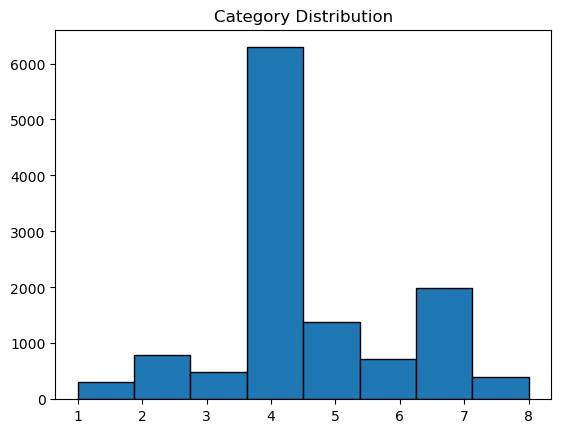

In [126]:
# Category distribution
plt.hist(data_train["category"], bins=8, edgecolor='black')
plt.title("Category Distribution")
plt.show()

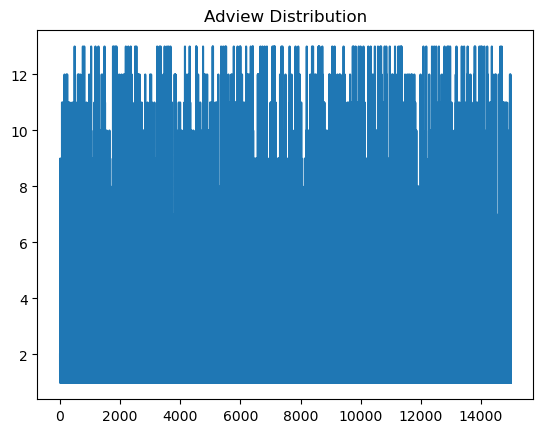

In [127]:
# Adview distribution
plt.plot(data_train["adview"])
plt.title("Adview Distribution")
plt.show()

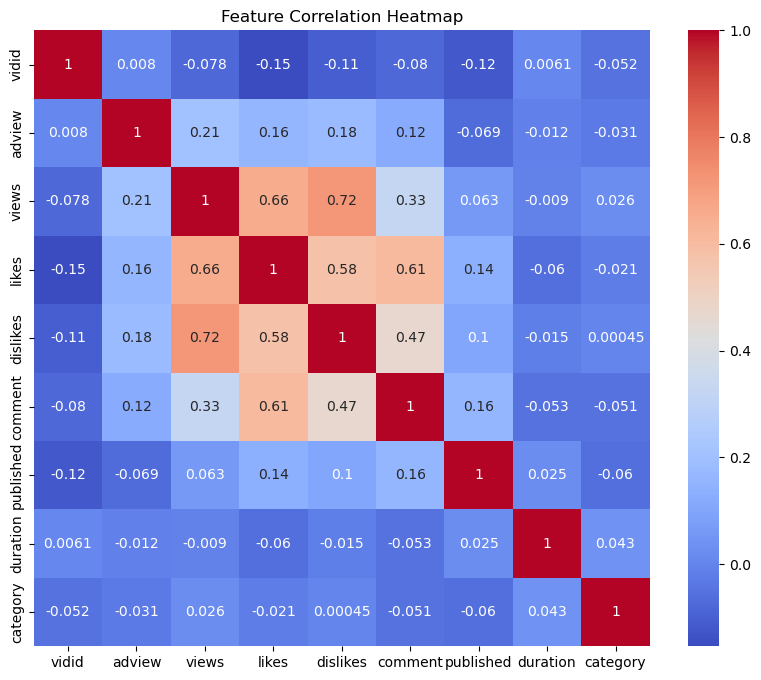

In [128]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = data_train.corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


In [129]:
print("Final Processed Data:\n", data_train.head())

Final Processed Data:
    vidid  adview   views  likes  dislikes  comment  published  duration  \
1   2318       2    1707     56         2        6       2116       570   
2   6850       1    2023     25         0        2       2025       136   
3   7494       6  620860    777       161      153       2050       262   
4    109       1     666      1         0        0       2022        31   
5    445       4      78      0         0        0       1971        15   

   category  
1         4  
2         3  
3         8  
4         4  
5         4  


In [130]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Features and target
X = data_train.drop(["adview", "vidid"], axis=1)
y = data_train["adview"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Normalise Data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)  # fit on train
X_test = scaler.transform(X_test)        # transform on test only

print("X_train mean:", X_train.mean())
print("X_train min:", X_train.min())
print("X_train max:", X_train.max())


X_train shape: (9895, 7)
X_test shape: (2474, 7)
X_train mean: 0.1760142325115652
X_train min: 0.0
X_train max: 1.0000000000000002


In [131]:
# Evaluation Metrics
from sklearn import metrics

def print_error(X_test, y_test, model):
    prediction = model.predict(X_test)
    print(f"Model: {model.__class__.__name__}")
    print("Mean Absolute Error:", metrics.mean_absolute_error(y_test, prediction))
    print("Mean Squared Error:", metrics.mean_squared_error(y_test, prediction))
    print("Root Mean Squared Error:", np.sqrt(metrics.mean_squared_error(y_test, prediction)))
    print("-" * 50)

In [132]:
# Linear Regression
from sklearn import linear_model
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)
print_error(X_test, y_test, linear_regression)

Model: LinearRegression
Mean Absolute Error: 1.9000415677890516
Mean Squared Error: 7.015570376462049
Root Mean Squared Error: 2.6486922011555154
--------------------------------------------------


In [133]:
# Support Vector Regressor
from sklearn.svm import SVR
supportvector_regressor = SVR(kernel="rbf")
supportvector_regressor.fit(X_train, y_train)
print_error(X_test, y_test, supportvector_regressor)

Model: SVR
Mean Absolute Error: 1.660734063554607
Mean Squared Error: 8.252063842930113
Root Mean Squared Error: 2.87264056974243
--------------------------------------------------


In [134]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
print_error(X_test, y_test, decision_tree)

Model: DecisionTreeRegressor
Mean Absolute Error: 2.058609539207761
Mean Squared Error: 11.0125303152789
Root Mean Squared Error: 3.3185132688116377
--------------------------------------------------


In [135]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

n_estimators = 200
max_depth = 25
min_samples_split = 15
min_samples_leaf = 2

random_forest = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=42
)

random_forest.fit(X_train, y_train)
print_error(X_test, y_test, random_forest)

Model: RandomForestRegressor
Mean Absolute Error: 1.6714556199494564
Mean Squared Error: 5.859236330446334
Root Mean Squared Error: 2.420585947750324
--------------------------------------------------


In [139]:
# Artificial Neural Network
import keras
from keras.layers import Dense

In [152]:
# ANN Model
ann = keras.models.Sequential([
    Dense(6, activation="relu", input_shape=X_train.shape[1:]),
    Dense(6, activation="relu"),
    Dense(1)
])
# Compile model
optimizer = keras.optimizers.Adam()
loss = keras.losses.mean_squared_error
ann.compile(optimizer=optimizer, loss=loss, metrics=["mean_squared_error"])

C:\Users\vijay\.conda\envs\mlenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [145]:
# Train model
history = ann.fit(X_train, y_train, epochs=50)

Epoch 1/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.9490 - mean_squared_error: 5.9490
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.8664 - mean_squared_error: 5.8664
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1518 - mean_squared_error: 6.1518
Epoch 4/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2050 - mean_squared_error: 6.2050
Epoch 5/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0260 - mean_squared_error: 6.0260
Epoch 6/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.4194 - mean_squared_error: 6.4194
Epoch 7/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0925 - mean_squared_error: 6.0925
Epoch 8/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.3490 - mean_squared_error: 6.3490
Epoch 9/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2393 - mean_squared_error: 6.2393
Epoch 10/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.0924 - mean_squared_error: 6.0924
Epoch 11/50
310/310 ━━━━━━━━━━━━━━━━━━━

In [146]:
# Model summary
ann.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 6)                   │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 293 (1.15 KB)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 196 (788.00 B)

In [147]:
# Evaluate
print_error(X_test, y_test, ann)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model: Sequential
Mean Absolute Error: 1.8214555503190673
Mean Squared Error: 6.7404786597874535
Root Mean Squared Error: 2.5962431819433736
--------------------------------------------------


In [154]:
from sklearn.metrics import r2_score

# Evaluate Decision Tree
dt_score = r2_score(y_test, decision_tree.predict(X_test))

# Evaluate Random Forest
rf_score = r2_score(y_test, random_forest.predict(X_test))

# Evaluate Linear Regression
lr_score = r2_score(y_test, linear_regression.predict(X_test))

# Evaluate SVR
svm_score = r2_score(y_test, supportvector_regressor.predict(X_test))

# Evaluate ANN
ann_pred = ann.predict(X_test)
ann_score = r2_score(y_test, ann_pred)

# Print comparison
print("Model Performance Comparison (R² Score):")
print(f"Decision Tree R²: {dt_score:.4f}")
print(f"Random Forest R²: {rf_score:.4f}")
print(f"Linear Regression R²: {lr_score:.4f}")
print(f"SVR R²: {svm_score:.4f}")
print(f"ANN R²: {ann_score:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Model Performance Comparison (R² Score):
Decision Tree R²: -0.4704
Random Forest R²: 0.2176
Linear Regression R²: 0.0632
SVR R²: -0.1019
ANN R²: -0.9811


In [155]:
# Saving the best performing model (Random Forest)
import joblib

joblib.dump(random_forest, "randomforest_youtubeadview.pkl")
print("Random Forest model saved as randomforest_youtubeadview.pkl")


Random Forest model saved as randomforest_youtubeadview.pkl


In [157]:
import joblib
import numpy as np

# Load saved model
model = joblib.load("randomforest_youtubeadview.pkl")

# Example input data (must match training features)
# Format: [views, likes, dislikes, comment, duration, published, adview]
X_new = np.array([[5000, 200, 5, 50, 300, 2150, 10]])  

prediction = model.predict(X_new)
print("Predicted value:", prediction)

Predicted value: [4.88923198]
